In [4]:
#Preparação de dados e econometria clássica
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.statespace.structural import UnobservedComponents
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.ar_model import AutoReg

#Modelos de Mudança de Regime (Modelo de Regressão com Mudança de Regime de Markov):
    # em vez de um único modelo de regressão para explicar a série inteira, há vários modelos
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from sklearn.cluster import KMeans

#Modelagem Bayesiana:
    # parâmetros como variáveis aleatórias: tem uma distribuição de probabilidade, portanto com incerteza
    #resultado é uma distribuição de probabilidade
        #prior: crença sobre o parâmetro antes de ver os dados
        #likelihood: como os dados são gerados, função de verossimilhança
        #posterior: crença atualizada sobre o parâmetro após ver os dados
import pymc as pm
import arviz as az
from sklearn.preprocessing import StandardScaler

#Visualização de dados
import plotly.graph_objects as go
import plotly.express as px
import plotly.colors 
import seaborn as sns
import warnings
from scipy.optimize import minimize
from pygam import LinearGAM, s, f
import plotly.graph_objects as go
import plotly.colors
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import os
import numpy as np
from pathlib import Path

#Modelos Aditivos Generalizados (GAM)
    # Em vez de forçar uma relação linear, o GAM substitui esse termo por uma função suave e flexível
    #spline:divide o intervalo de $x$ em seções (definidas por "nós" ou knots) 
        # e ajusta funções mais simples (como pequenos polinômios cúbicos) em cada seção
from scipy.stats import norm

#Computação quântica: 
    #Uso de Otimização Combinatória: QAOA não é puramente quântico; ele é um algoritmo híbrido. 
        #Clássico 💻: O otimizador COBYLA (clássico) "chuta" um conjunto inicial de parâmetros (ângulos) para o circuito quântico.
        # Quântico ⚛️: O QAOAAnsatz (o circuito quântico) é montado com esses parâmetros. 
            # Ele é executado no processador quântico (ou simulador), usando superposição
            # e emaranhamento para explorar o vasto espaço de soluções do seu QuadraticProgram.
        # Quântico ⚛️: O circuito é medido, "colapsando" para uma solução candidata (ex: "rota A") e seu respectivo "custo".
        # Clássico 💻: O COBYLA recebe esse custo.
            # Ele então usa sua lógica clássica para decidir um novo conjunto de parâmetros para o circuito quântico, tentando obter um custo menor.


from qiskit import QuantumCircuit
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms import QAOA
from qiskit.circuit.library import TwoLocal, QAOAAnsatz
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
import numpy as np
import cupy as cp
from scipy.optimize import minimize
import time
from typing import Dict, List, Tuple



# Usar o Sampler correto dependendo da versão
try:
    # Para Qiskit >= 1.0
    from qiskit.primitives import Sampler
    QISKIT_NEW = True
except ImportError:
    # Para versões antigas
    try:
        from qiskit_aer.primitives import Sampler
        QISKIT_NEW = False
    except ImportError:
        # Fallback: usar StatevectorSampler
        from qiskit.primitives import StatevectorSampler as Sampler
        QISKIT_NEW = True

from qiskit.quantum_info import SparsePauliOp

# Machine Learning Clássico: 
    # Random Forest: Constrói  árvores independentes em paralelo usando aleatoriedade nos dados e nas features, e tira a média das previsões.
    # XGBoost: Constrói árvores sequencialmente, onde cada árvore aprende com os erros das anteriores,
        # usando otimizações de gradiente e regularização para alta performance e controle de overfitting.

# Importações necessárias para Machiene Learning com GPU
try:
    from cuml.ensemble import RandomForestRegressor
    import xgboost as xgb
    print("  → 'cuml.RandomForestRegressor' e 'xgboost' importados.")
    USE_GPU_ML = True
except ImportError as e:
    print(f"⚠ Falha ao importar bibliotecas de GPU (cuml/xgboost): {e}")
    print("  → Usando fallback para YDF (CPU).")
    USE_GPU_ML = False

import ydf
import tensorflow as tf


#VARMAX:
    # analisar e prever múltiplas séries temporais que são interdependentes e também podem ser influenciadas por variáveis externas.
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import grangercausalitytests

from tqdm import tqdm
import time

warnings.filterwarnings("ignore")

print(f"Usando PyMC versão: {pm.__version__}")
print(f"Modo Qiskit: {'Novo (>=1.0)' if QISKIT_NEW else 'Legacy'}")
print("="*80)
print("INICIANDO PIPELINE DE MODELOS")
print("="*80)

  → 'cuml.RandomForestRegressor' e 'xgboost' importados.
Usando PyMC versão: 5.27.0
Modo Qiskit: Legacy
INICIANDO PIPELINE DE MODELOS



DADOS SIMULADOS (com garantia de positividade para PIB_pc, Industrializacao, Educacao):
Gini por Regime: {0: 0.4, 1: 0.43, 2: 0.46}
Primeiras linhas do DataFrame:
    Ano      PIB_pc  Urbanizacao  Industrializacao  Educacao  Gini_Verdadeiro  \
0  1872  417.208801         0.05          0.000000  0.013242         0.350000   
1  1873  395.155205         0.05          0.000000  0.000000         0.350000   
2  1874  467.381449         0.05          0.036170  0.000000         0.376359   
3  1875  519.945747         0.05          0.016229  0.011559         0.350000   
4  1876  559.001227         0.05          0.035544  0.002394         0.350000   

   Regime_Verdadeiro  Gini_Observado  
0                  0             NaN  
1                  0             NaN  
2                  0             NaN  
3                  0             NaN  
4                  0             NaN  

Valores mínimos simulados:
  PIB_pc Min: 395.1552
  Industrializacao Min: 0.0000
  Educacao Min: 0.0000


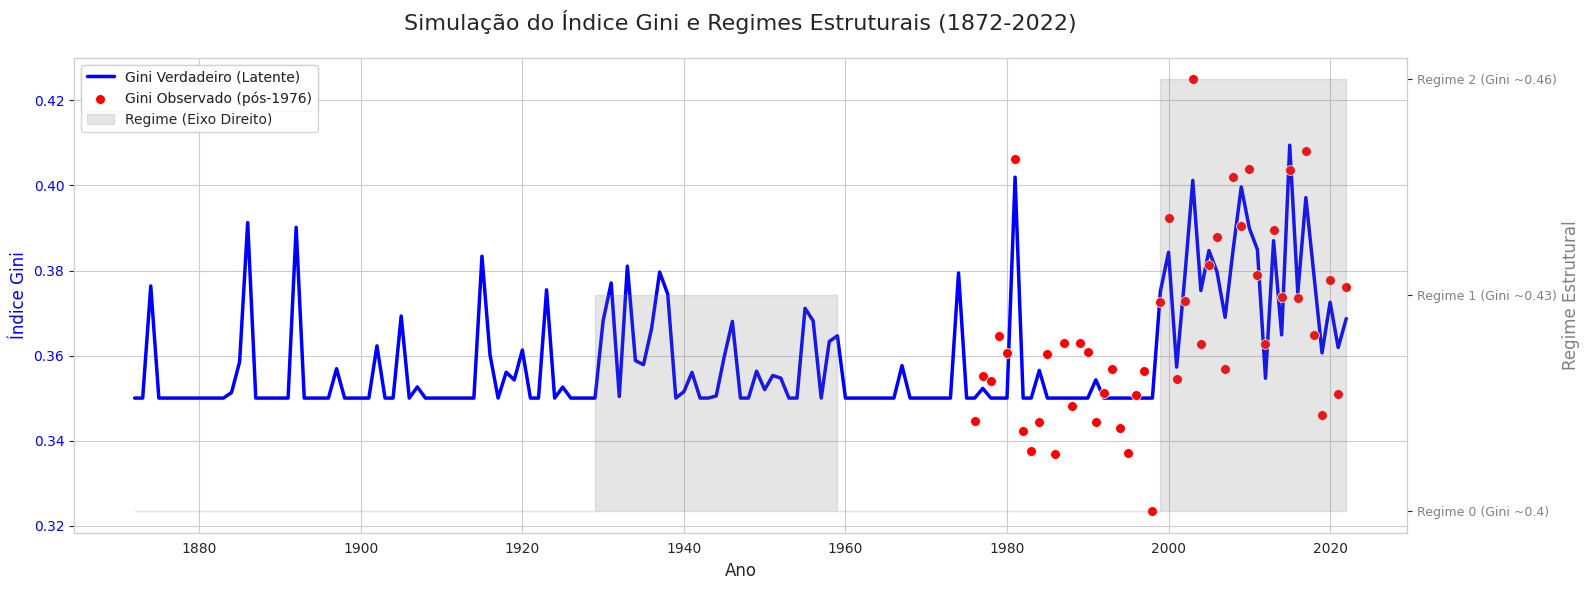

✓ Gráfico Gini vs Regimes salvo como gini_regimes_plot.png


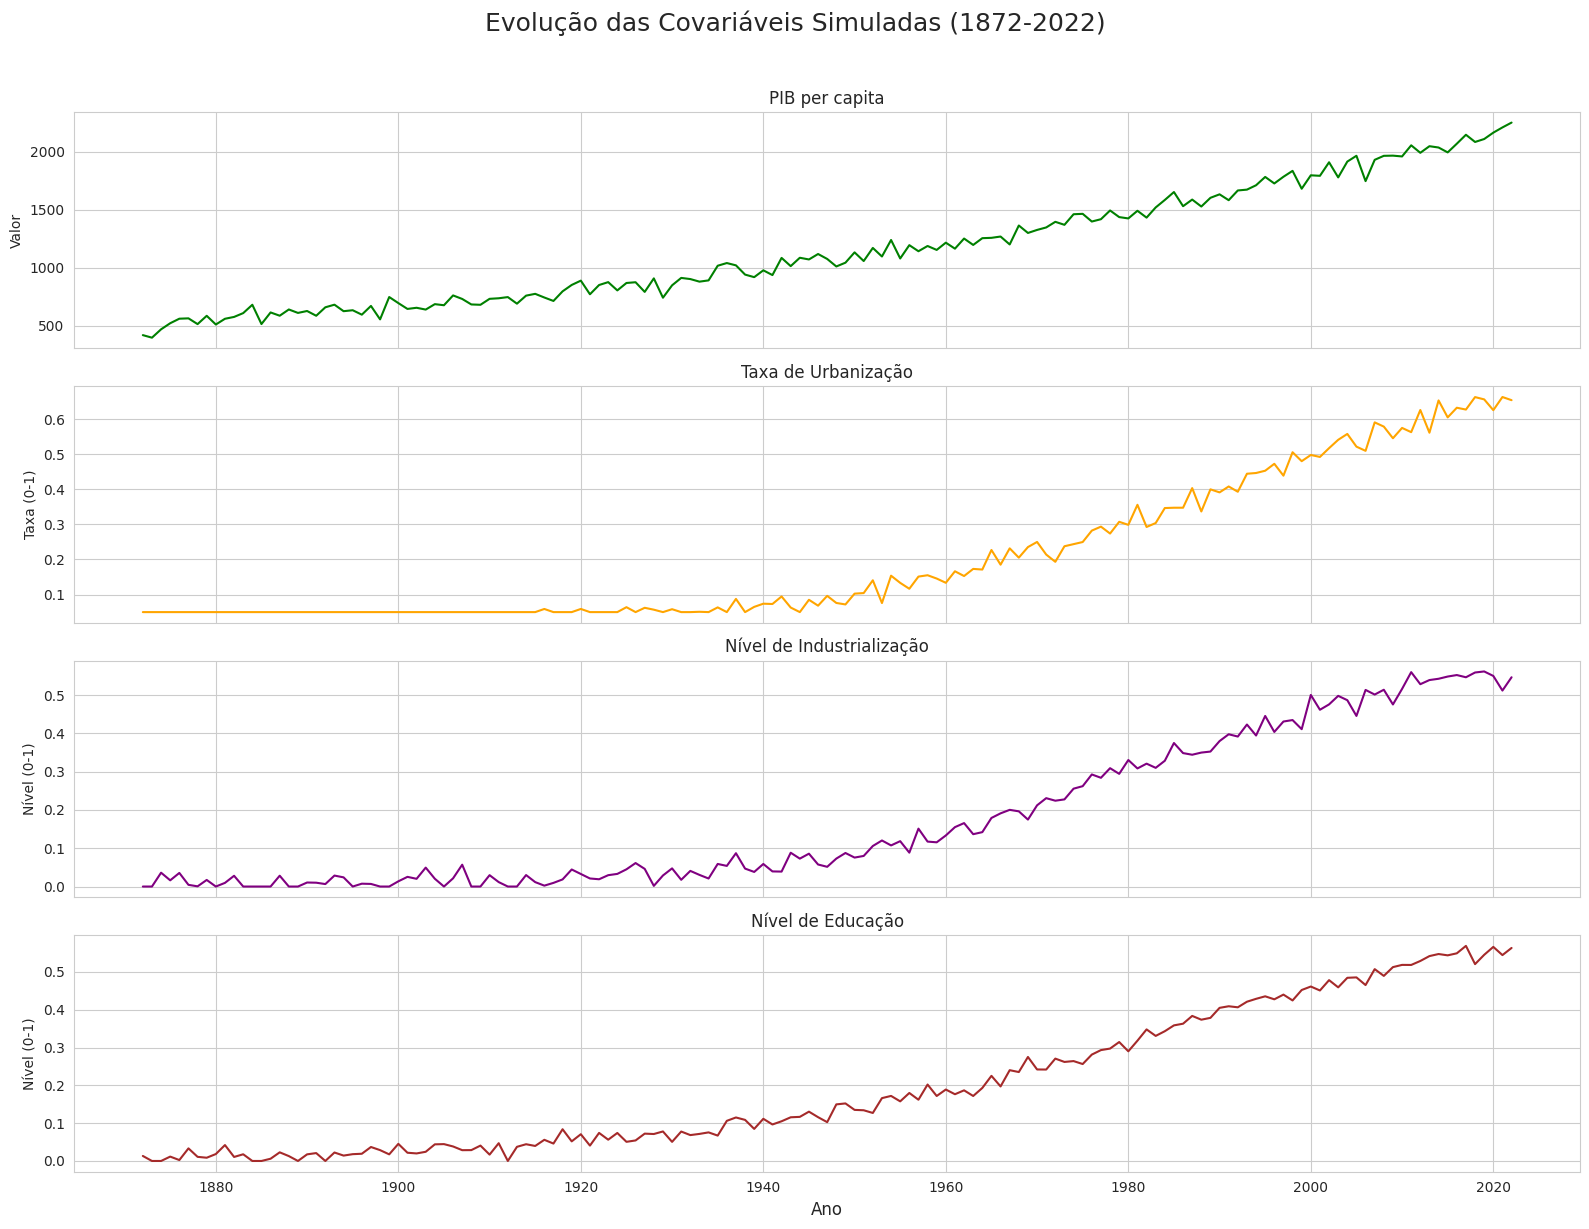

✓ Gráfico Covariáveis salvo como covariaveis_plot.png

[Seleção de Lags via AIC]
→ Selecionando número de lags para Gini (max 10)...
⚠ Erro de atributo ('AutoReg' object has no attribute 'k_ar'), tentando fallback 'select_order' (versão antiga)...
⚠ Fallback 'select_order' também falhou ('AutoReg' object has no attribute 'select_order'), usando k=1.
✓ Número de lags selecionados (k): 1
→ Criando colunas de lag no DataFrame principal...
  ✓ Coluna 'Gini_Lag_1' criada e preenchida.
→ Atualizando DataFrames moderno e histórico...
  ✓ df_moderno (47 obs) e df_historico (104 obs) atualizados.

Primeiras linhas do DataFrame com colunas de lag:
    Ano      PIB_pc  Urbanizacao  Industrializacao  Educacao  Gini_Verdadeiro  \
0  1872  417.208801         0.05          0.000000  0.013242         0.350000   
1  1873  395.155205         0.05          0.000000  0.000000         0.350000   
2  1874  467.381449         0.05          0.036170  0.000000         0.376359   
3  1875  519.945747         0.

In [5]:
# ===========================
# 0. SIMULAÇÃO DE DADOS 
# ===========================

np.random.seed(1872)
anos = np.arange(1872, 2023)
n_anos = len(anos)

# Simula PIB per capita e garante não-negatividade
pib_pc = 500 * np.exp(np.linspace(0, 1.5, n_anos)) + np.random.normal(0, 50, n_anos)
pib_pc = np.maximum(pib_pc, 0) # Garante que pib_pc >= 0

# Simula Urbanizacao (já clipado entre 0.05 e 0.85, então é positivo)
urbanizacao = 0.8 / (1 + np.exp(-0.05 * (anos - 1990))) + np.random.normal(0, 0.02, n_anos)
urbanizacao = np.clip(urbanizacao, 0.05, 0.85)

# Simula Industrializacao e garante não-negatividade
industrializacao = 0.6 / (1 + np.exp(-0.06 * (anos - 1980))) + np.random.normal(0, 0.02, n_anos)
industrializacao = np.maximum(industrializacao, 0) # Garante que industrializacao >= 0

# Simula Educacao e garante não-negatividade
educacao = 0.7 / (1 + np.exp(-0.04 * (anos - 1985))) + np.random.normal(0, 0.015, n_anos)
educacao = np.maximum(educacao, 0) # Garante que educacao >= 0

regimes_verdadeiros = np.zeros(n_anos, dtype=int)
gini_por_regime = {0: 0.40, 1: 0.43, 2: 0.46}
volatilidade_regime = {0: 0.025, 1: 0.015, 2: 0.020}
regime_atual = 0
for i in range(n_anos):
    ano_atual = anos[i]
    if ano_atual < 1930: regime_atual = 0
    elif 1930 <= ano_atual < 1960: regime_atual = 1
    elif 1960 <= ano_atual < 2000: regime_atual = 0
    else: regime_atual = 2
    regimes_verdadeiros[i] = regime_atual

tendencia = 0.6 - 0.10 * ((anos - 1872) / 150)
ciclica = -0.05 * np.sin(np.pi * (anos - 1872) / 40)
estrutural = 0.03 * np.cos(np.pi * (anos - 1872) / 25)
gini_regime = np.array([gini_por_regime[r] for r in regimes_verdadeiros])
noise_regime = np.array([np.random.normal(0, volatilidade_regime[r]) for r in regimes_verdadeiros])
gini_real = 0.1 * tendencia + 0.7 * gini_regime + 0.1 * ciclica + 0.1 * estrutural + noise_regime
gini_real = np.clip(gini_real, 0.35, 0.55)

df = pd.DataFrame({
    'Ano': anos, 'PIB_pc': pib_pc, 'Urbanizacao': urbanizacao,
    'Industrializacao': industrializacao, 'Educacao': educacao,
    'Gini_Verdadeiro': gini_real, 'Regime_Verdadeiro': regimes_verdadeiros
})

ano_inicio_pnad = 1976
# Criar Gini_Observado para seleção de lags
df['Gini_Observado'] = np.nan
mask_moderno_inicial = df['Ano'] >= ano_inicio_pnad
df.loc[mask_moderno_inicial, 'Gini_Observado'] = df.loc[mask_moderno_inicial, 'Gini_Verdadeiro'] + \
                                                np.random.normal(0, 0.01, mask_moderno_inicial.sum())
n_total = len(df)

print("\nDADOS SIMULADOS (com garantia de positividade para PIB_pc, Industrializacao, Educacao):")
print(f"Gini por Regime: {gini_por_regime}")
print("Primeiras linhas do DataFrame:")
print(df.head())
# Verifica valores mínimos (opcional)
print("\nValores mínimos simulados:")
print(f"  PIB_pc Min: {df['PIB_pc'].min():.4f}")
print(f"  Industrializacao Min: {df['Industrializacao'].min():.4f}")
print(f"  Educacao Min: {df['Educacao'].min():.4f}")
print("="*80)

# --- VISUALIZAÇÃO DOS DADOS ---
# Presume que matplotlib e seaborn foram importados no bloco principal de imports
import matplotlib.pyplot as plt
import seaborn as sns

df_moderno_grafico = df[df['Ano'] >= ano_inicio_pnad].copy()
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

# Gráfico 1: Gini e Regimes
fig, ax1 = plt.subplots(figsize=(16, 6))
sns.lineplot(data=df, x='Ano', y='Gini_Verdadeiro', label='Gini Verdadeiro (Latente)', ax=ax1, color='blue', linewidth=2.5)
sns.scatterplot(data=df_moderno_grafico, x='Ano', y='Gini_Observado', label=f'Gini Observado (pós-{ano_inicio_pnad})', ax=ax1, color='red', s=50, zorder=5)
ax1.set_title('Simulação do Índice Gini e Regimes Estruturais (1872-2022)', fontsize=16, pad=20)
ax1.set_ylabel('Índice Gini', fontsize=12, color='blue')
ax1.set_xlabel('Ano', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.fill_between(df['Ano'], df['Regime_Verdadeiro'], step='pre', alpha=0.2, color='gray', label='Regime (Eixo Direito)')
ax2.set_ylabel('Regime Estrutural', fontsize=12, color='gray')
ax2.tick_params(axis='y', labelcolor='gray', labelsize=9)
tick_locs = np.unique(regimes_verdadeiros)
ax2.set_yticks(tick_locs)
regime_nomes = [f"Regime {r} (Gini ~{gini_por_regime[r]})" for r in tick_locs]
ax2.set_yticklabels(regime_nomes)
ax2.grid(False)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')
plt.tight_layout()
plt.savefig("gini_regimes_plot.png")
plt.show() # Descomente para mostrar o gráfico interativamente se não estiver em ambiente como VS Code/Jupyter
plt.close(fig) # Fecha a figura para não aparecer inline depois
print("✓ Gráfico Gini vs Regimes salvo como gini_regimes_plot.png")

# Gráfico 2: Covariáveis
fig, axes = plt.subplots(4, 1, figsize=(16, 12), sharex=True)
fig.suptitle('Evolução das Covariáveis Simuladas (1872-2022)', fontsize=18, y=1.02)
sns.lineplot(data=df, x='Ano', y='PIB_pc', ax=axes[0], color='green'); axes[0].set_title('PIB per capita', fontsize=12); axes[0].set_ylabel('Valor')
sns.lineplot(data=df, x='Ano', y='Urbanizacao', ax=axes[1], color='orange'); axes[1].set_title('Taxa de Urbanização', fontsize=12); axes[1].set_ylabel('Taxa (0-1)')
sns.lineplot(data=df, x='Ano', y='Industrializacao', ax=axes[2], color='purple'); axes[2].set_title('Nível de Industrialização', fontsize=12); axes[2].set_ylabel('Nível (0-1)')
sns.lineplot(data=df, x='Ano', y='Educacao', ax=axes[3], color='brown'); axes[3].set_title('Nível de Educação', fontsize=12); axes[3].set_ylabel('Nível (0-1)')
axes[3].set_xlabel('Ano', fontsize=12)
plt.tight_layout()
plt.savefig("covariaveis_plot.png")
plt.show() # Descomente para mostrar o gráfico interativamente
plt.close(fig) # Fecha a figura
print("✓ Gráfico Covariáveis salvo como covariaveis_plot.png")
print("="*80)


# --- SELEÇÃO DE LAGS PARA O GINI (BASEADO NO AIC) ---
# Presume que AutoReg foi importado no bloco principal de imports

print("\n[Seleção de Lags via AIC]")
print("→ Selecionando número de lags para Gini (max 10)...")
gini_moderno_observado = df.loc[mask_moderno_inicial, 'Gini_Observado'].dropna()

k_lags_selecionados = 1 # Valor padrão caso a seleção falhe

if len(gini_moderno_observado) > 10: # Checagem mínima de dados
    try:
        # A sintaxe moderna (statsmodels > 0.11) seleciona automaticamente 
        # o melhor lag (baseado no AIC por padrão) quando 'lags' é um inteiro.
        model_select = AutoReg(gini_moderno_observado, lags=10, trend='n', old_names=False) 
        results_select = model_select.fit(cov_type="nonrobust") # Ajusta o modelo com a melhor ordem
        
        # ***** CORREÇÃO APLICADA AQUI *****
        # O lag selecionado está em 'results_select.model.k_ar'
        k_lags_selecionados = results_select.model.k_ar 
        
        if k_lags_selecionados == 0: 
            k_lags_selecionados = 1 # Evitar 0 lags
            
    except AttributeError as e:
        # Fallback para a sintaxe antiga (select_order), caso o erro acima persista
        print(f"⚠ Erro de atributo ({e}), tentando fallback 'select_order' (versão antiga)...")
        try:
             ar_mod_sel = AutoReg(gini_moderno_observado, lags=10, trend='n') 
             sel_res = ar_mod_sel.select_order(maxlag=10, ic='aic')
             k_lags_selecionados = sel_res.aic if sel_res.aic > 0 else 1
        except Exception as e2:
            print(f"⚠ Fallback 'select_order' também falhou ({e2}), usando k=1.")
            k_lags_selecionados = 1
            
    except Exception as e:
        print(f"⚠ Erro inesperado na seleção automática de lags ({e}), usando k=1.")
        k_lags_selecionados = 1
else:
    print("⚠ Dados insuficientes para seleção automática, usando k=1.")
    k_lags_selecionados = 1


print(f"✓ Número de lags selecionados (k): {k_lags_selecionados}")

# --- CRIAÇÃO DAS COLUNAS DE LAG ---
print("→ Criando colunas de lag no DataFrame principal...")
lag_cols_names = []
for i in range(1, k_lags_selecionados + 1):
    col_name = f'Gini_Lag_{i}'
    df[col_name] = df['Gini_Verdadeiro'].shift(i)
    # Preencher NaNs iniciais com o primeiro valor de Gini_Verdadeiro
    df[col_name].fillna(df['Gini_Verdadeiro'].iloc[0], inplace=True)
    lag_cols_names.append(col_name)
    print(f"  ✓ Coluna '{col_name}' criada e preenchida.")

# --- ATUALIZAR df_moderno e df_historico ---
print("→ Atualizando DataFrames moderno e histórico...")
df_moderno = df[df['Ano'] >= ano_inicio_pnad].copy()
df_historico = df[df['Ano'] < ano_inicio_pnad].copy()
n_historico = len(df_historico)
n_moderno = len(df_moderno)
print(f"  ✓ df_moderno ({n_moderno} obs) e df_historico ({n_historico} obs) atualizados.")

print("\nPrimeiras linhas do DataFrame com colunas de lag:")
print(df.head())
print("="*80)

# --- LISTA DE PREDITORES BASE E DE LAGS ---
predictors_base = ['PIB_pc', 'Urbanizacao', 'Industrializacao', 'Educacao']
predictors_lags = lag_cols_names
# --- FIM DAS LISTAS ---


In [6]:
# ===========================
# 1. MODELO OLS BASELINE (com k lags)
# ===========================
print(f"\n[1] MODELO OLS (Baseline com k={k_lags_selecionados} Lags)")
predictors_ols = predictors_base + predictors_lags # Combina base + lags
print(f"→ Preditores OLS: {predictors_ols}")

with tqdm(total=100, desc="OLS", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}') as pbar:
    X_moderno_ols = df_moderno[predictors_ols]
    X_moderno_ols = sm.add_constant(X_moderno_ols)
    y_moderno_ols = df_moderno['Gini_Observado']
    pbar.update(30)

    modelo_ols = sm.OLS(y_moderno_ols, X_moderno_ols).fit()
    pbar.update(40)

    X_historico_ols = df_historico[predictors_ols]
    X_historico_ols = sm.add_constant(X_historico_ols)
    df_historico['Gini_OLS'] = modelo_ols.predict(X_historico_ols)
    pbar.update(30)

print(f"✓ R²: {modelo_ols.rsquared:.4f} | AIC: {modelo_ols.aic:.2f}")
print(modelo_ols.summary())
print("="*80)


[1] MODELO OLS (Baseline com k=1 Lags)
→ Preditores OLS: ['PIB_pc', 'Urbanizacao', 'Industrializacao', 'Educacao', 'Gini_Lag_1']


OLS: 100%|██████████| 100/100

✓ R²: 0.2597 | AIC: -226.71
                            OLS Regression Results                            
Dep. Variable:         Gini_Observado   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     2.876
Date:                Mon, 12 Jan 2026   Prob (F-statistic):             0.0257
Time:                        13:22:11   Log-Likelihood:                 119.36
No. Observations:                  47   AIC:                            -226.7
Df Residuals:                      41   BIC:                            -215.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const       

In [7]:
# ===========================
# 2. MARKOV SWITCHING REGRESSION (com k lags)
# ===========================
print(f"\n[2] MARKOV SWITCHING REGRESSION (com k={k_lags_selecionados} Lags)")
predictors_markov_base_subset = ['PIB_pc', 'Urbanizacao'] # Usando subconjunto base para Markov
predictors_markov = predictors_markov_base_subset + predictors_lags # Combina subconjunto base + lags
print(f"→ Preditores Markov: {predictors_markov}")

X_markov = df_moderno[predictors_markov].values
y_markov = df_moderno['Gini_Observado'].values
X_markov_const = sm.add_constant(X_markov)

# --- Atualizar número de preditores para Markov ---
num_predictors_markov = X_markov_const.shape[1] # Usa a forma de X_markov_const
print(f"  (Número total de coeficientes por regime: {num_predictors_markov})")
# --- Fim da atualização ---

try:
    with tqdm(total=100, desc="Markov", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}') as pbar:
        pbar.set_postfix_str("Inicializando modelo...")
        
        # ***** CORREÇÃO 1: Adicionado trend='n' para evitar colinearidade com sm.add_constant *****
        modelo_markov = MarkovRegression(
            endog=y_markov, k_regimes=2, exog=X_markov_const, trend='n', switching_variance=True
        )
        pbar.update(20)

        pbar.set_postfix_str("Estimando (max 500 iter)...")
        resultado_markov = modelo_markov.fit(maxiter=500, disp=False)
        pbar.update(60)

        prob_regimes = resultado_markov.smoothed_marginal_probabilities
        regime_mais_provavel = np.argmax(prob_regimes, axis=1)
        pbar.update(10)

        # Backcasting
        X_hist_markov = df_historico[predictors_markov].values
        X_hist_markov_const = sm.add_constant(X_hist_markov)
        ultimo_regime = regime_mais_provavel[-1]

        # --- Ajustar índices dos parâmetros dinamicamente ---
        params = resultado_markov.params
        if ultimo_regime == 0:
             coefs_pred = params[:num_predictors_markov]
        else:
             coefs_pred = params[num_predictors_markov:(2 * num_predictors_markov)]
        # --- Fim do ajuste ---

        df_historico['Gini_Markov'] = X_hist_markov_const @ coefs_pred
        pbar.update(5)

        # ***** CORREÇÃO 2: Buscar sigma2 (variâncias) nos locais corretos *****
        # As variâncias (sigma2) vêm DEPOIS de todos os coeficientes de regime
        sigma2_idx_start = modelo_markov.k_regimes * num_predictors_markov
        sigma2_idx_end = sigma2_idx_start + modelo_markov.k_regimes
        sigma_regime = np.sqrt(params[sigma2_idx_start:sigma2_idx_end])
        # ***** Fim da correção 2 *****
        
        sigma_usado = sigma_regime[ultimo_regime]
        df_historico['Gini_Markov_Low'] = df_historico['Gini_Markov'] - 1.96 * sigma_usado
        df_historico['Gini_Markov_High'] = df_historico['Gini_Markov'] + 1.96 * sigma_usado
        pbar.update(5)

        df_moderno['Prob_Regime_0'] = prob_regimes[:, 0]
        df_moderno['Prob_Regime_1'] = prob_regimes[:, 1]
        df_moderno['Regime_Inferido'] = regime_mais_provavel

        markov_success = True

    print(f"✓ Convergência OK | AIC: {resultado_markov.aic:.2f}")
    print("\n" + "="*80)
    print("SUMÁRIO DO MODELO MARKOV SWITCHING (treinado nos dados modernos)")
    print("="*80)
    print(resultado_markov.summary())
    print("="*80)

except Exception as e:
    print(f"⚠ Falhou: {e}")
    print("→ Usando K-means como fallback...")

    # K-means e OLS por cluster
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    kmeans_data = np.column_stack([y_markov, X_markov])
    regime_mais_provavel = kmeans.fit_predict(kmeans_data)

    coefs_regimes = []
    for r in range(2):
        mask = regime_mais_provavel == r
        X_r = X_markov_const[mask]
        y_r = y_markov[mask]
        # Adiciona uma checagem para garantir que o cluster não está vazio
        if X_r.shape[0] > X_r.shape[1]: # Mais observações que preditores
            coefs_r = np.linalg.lstsq(X_r, y_r, rcond=None)[0]
            coefs_regimes.append(coefs_r)
        else:
            print(f"⚠ Cluster {r} tem dados insuficientes ({X_r.shape[0]} obs) para OLS. Usando NaNs.")
            coefs_regimes.append(np.full(num_predictors_markov, np.nan)) # Adiciona NaNs se falhar

    # Fallback para o último regime (se os coeficientes forem válidos)
    ultimo_regime = regime_mais_provavel[-1]
    if ultimo_regime < len(coefs_regimes) and not np.isnan(coefs_regimes[ultimo_regime]).any():
        X_hist_markov_const = sm.add_constant(df_historico[predictors_markov].values)
        df_historico['Gini_Markov'] = X_hist_markov_const @ coefs_regimes[ultimo_regime]
        print("\n" + "="*80)
        print("SUMÁRIO DO FALLBACK (K-Means + OLS por cluster)")
        print("="*80)
        print(f"Clusters (regimes) encontrados: {len(coefs_regimes)}")
        print(f"Variáveis usadas no OLS: ['const'] + {predictors_markov}")
        for r, coefs in enumerate(coefs_regimes):
            print(f"\n--- Coeficientes para Regime (Cluster) {r} ---")
            if not np.isnan(coefs).any():
                print(f"  const: {coefs[0]:.6f}")
                for i, pred_name in enumerate(predictors_markov):
                     if i+1 < len(coefs): print(f"  {pred_name}: {coefs[i+1]:.6f}")
            else:
                 print("  (Coeficientes NaN - dados insuficientes)")

        print(f"\nÚltimo regime observado: {ultimo_regime}")
        print(f"→ Coeficientes do Regime {ultimo_regime} serão usados para o backcasting.")
    else:
        print("\n" + "="*80)
        print("SUMÁRIO DO FALLBACK (K-Means + OLS por cluster)")
        print("="*80)
        print(f"⚠ Fallback K-Means também falhou (cluster vazio ou dados insuficientes).")
        df_historico['Gini_Markov'] = np.nan # Define como NaN se o fallback falhar

    # Intervalos de confiança fixos no fallback
    df_historico['Gini_Markov_Low'] = df_historico['Gini_Markov'] - 0.03 # Intervalo fixo
    df_historico['Gini_Markov_High'] = df_historico['Gini_Markov'] + 0.03 # Intervalo fixo
    df_moderno['Regime_Inferido'] = regime_mais_provavel
    markov_success = False
    
    print("="*80)


[2] MARKOV SWITCHING REGRESSION (com k=1 Lags)
→ Preditores Markov: ['PIB_pc', 'Urbanizacao', 'Gini_Lag_1']
  (Número total de coeficientes por regime: 4)


Markov:  20%|██        | 20/100

⚠ Falhou: Steady-state probabilities could not be constructed.
→ Usando K-means como fallback...



SUMÁRIO DO FALLBACK (K-Means + OLS por cluster)
Clusters (regimes) encontrados: 2
Variáveis usadas no OLS: ['const'] + ['PIB_pc', 'Urbanizacao', 'Gini_Lag_1']

--- Coeficientes para Regime (Cluster) 0 ---
  const: 0.382153
  PIB_pc: -0.000148
  Urbanizacao: 0.335148
  Gini_Lag_1: 0.238504

--- Coeficientes para Regime (Cluster) 1 ---
  const: 0.176603
  PIB_pc: 0.000103
  Urbanizacao: -0.207605
  Gini_Lag_1: 0.297377

Último regime observado: 1
→ Coeficientes do Regime 1 serão usados para o backcasting.


In [8]:
# ===========================
# 3. GENERALIZED ADDITIVE MODELS (GAMs) (com k lags)
# ===========================
print(f"\n[3] GENERALIZED ADDITIVE MODELS (GAMs com k={k_lags_selecionados} Lags)")
predictors_gam = predictors_base + predictors_lags # Combina base + lags
print(f"→ Preditores GAM: {predictors_gam}")

X_gam_treino = df_moderno[predictors_gam].values
y_gam_treino = df_moderno['Gini_Observado'].values

# --- Ajustar n_splines_list e gam_terms dinamicamente ---
n_splines_base = [8, 6, 6, 6]
n_splines_lags = [6] * k_lags_selecionados
n_splines_list = n_splines_base + n_splines_lags
print(f"  (Número de splines por preditor: {n_splines_list})")

gam_terms = None
num_total_predictors_gam = len(predictors_gam)
for i in range(num_total_predictors_gam):
    term = s(i, n_splines=n_splines_list[i])
    if gam_terms is None:
        gam_terms = term
    else:
        gam_terms += term
# --- Fim do ajuste ---


with tqdm(total=100, desc="GAM", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}') as pbar:
    pbar.set_postfix_str("Grid search...")
    gam_model = LinearGAM(gam_terms)

    gam_model.gridsearch(X_gam_treino, y_gam_treino)
    pbar.update(70)

    X_gam_historico = df_historico[predictors_gam].values
    df_historico['Gini_GAM'] = gam_model.predict(X_gam_historico)
    pbar.update(20)

    gam_intervals = gam_model.prediction_intervals(X_gam_historico, width=0.95)
    df_historico['Gini_GAM_Low'] = gam_intervals[:, 0]
    df_historico['Gini_GAM_High'] = gam_intervals[:, 1]
    pbar.update(10)

print(f"✓ Pseudo R²: {gam_model.statistics_['pseudo_r2']['explained_deviance']:.4f}")
print("\n" + "="*80)
print("SUMÁRIO DO MODELO GAM (treinado nos dados modernos)")
print("="*80)
print(gam_model.summary())
print("="*80)


[3] GENERALIZED ADDITIVE MODELS (GAMs com k=1 Lags)
→ Preditores GAM: ['PIB_pc', 'Urbanizacao', 'Industrializacao', 'Educacao', 'Gini_Lag_1']
  (Número de splines por preditor: [8, 6, 6, 6, 6])


GAM:   0%|          | 0/100  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
GAM: 100%|██████████| 100/100

✓ Pseudo R²: 0.5812

SUMÁRIO DO MODELO GAM (treinado nos dados modernos)
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     11.9334
Link Function:                     IdentityLink Log Likelihood:                                   131.8282
Number of Samples:                           47 AIC:                                             -237.7896
                                                AICc:                                            -226.8899
                                                GCV:                                                0.0005
                                                Scale:                                              0.0166
                                                Pseudo R-Squared:      

In [9]:
# ===========================
# 4. SÉRIE TEMPORAL ESTRUTURAL (UCM )
# ===========================
print("\n[4] MODELO DE SÉRIE TEMPORAL ESTRUTURAL (UCM)")
ts_data = df_moderno.set_index('Ano')['Gini_Observado']

with tqdm(total=100, desc="TimeSeries", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}') as pbar:
    pbar.set_postfix_str("Modelo forward...")
    modelo_uc = UnobservedComponents(
        ts_data, level='local linear trend', cycle=True,
        stochastic_cycle=True, damped_cycle=True, irregular=True
    )
    resultado_uc = modelo_uc.fit(disp=False)
    pbar.update(40)

    pbar.set_postfix_str("Modelo backward...")
    ts_invertida = ts_data[::-1]
    modelo_uc_inv = UnobservedComponents(
        ts_invertida, level='local linear trend', cycle=True,
        stochastic_cycle=True, damped_cycle=True, irregular=True
    )
    resultado_uc_inv = modelo_uc_inv.fit(disp=False)
    pbar.update(40)

    pbar.set_postfix_str("Backcasting...")
    forecast_inv = resultado_uc_inv.forecast(steps=n_historico)
    df_historico['Gini_TimeSeries'] = forecast_inv[::-1].values
    forecast_summary = resultado_uc_inv.get_forecast(steps=n_historico).summary_frame(alpha=0.05)
    df_historico['Gini_TS_Low'] = forecast_summary['mean_ci_lower'][::-1].values
    df_historico['Gini_TS_High'] = forecast_summary['mean_ci_upper'][::-1].values
    pbar.update(20)

print(f"✓ AIC (modelo forward): {resultado_uc.aic:.2f}")
print("\n" + "="*80)
print("SUMÁRIO DO MODELO UCM (treinado nos dados modernos - forward)")
print("="*80)
print(resultado_uc.summary())
print("="*80)


[4] MODELO DE SÉRIE TEMPORAL ESTRUTURAL (UCM)


TimeSeries: 100%|██████████| 100/100

✓ AIC (modelo forward): -165.66

SUMÁRIO DO MODELO UCM (treinado nos dados modernos - forward)
                            Unobserved Components Results                            
Dep. Variable:                Gini_Observado   No. Observations:                   47
Model:                    local linear trend   Log Likelihood                  88.832
                   + damped stochastic cycle   AIC                           -165.663
Date:                       Mon, 12 Jan 2026   BIC                           -155.096
Time:                               13:22:14   HQIC                          -161.766
Sample:                                    0                                         
                                        - 47                                         
Covariance Type:                         opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------

In [10]:
# ===========================
# 6. MODELO BAYESIANO HIERÁRQUICO (com k lags)
# ===========================
print(f"\n[6] MODELO BAYESIANO HIERÁRQUICO (OTIMIZADO com k={k_lags_selecionados} Lags)")

if df_moderno.empty or len(df_moderno) < 10:
    print("⚠ Dados insuficientes para modelo Bayesiano. Pulando...")
    df_historico['Gini_Bayes_Hierarquico'] = np.nan
    df_historico['Gini_Bayes_Low'] = np.nan
    df_historico['Gini_Bayes_High'] = np.nan
else:
    # --- Atualizar colunas para normalização e coords ---
    print(f"→ Normalizando preditores (incluindo {k_lags_selecionados} lags)...")
    scaler_bayes = StandardScaler()
    cols_norm_bayes = predictors_base + predictors_lags # Usa k lags
    norm_cols_names_bayes = [col + '_norm' for col in predictors_base] + \
                            [col + '_norm' for col in predictors_lags] # Nomes normalizados
    print(f"  (Colunas normalizadas: {norm_cols_names_bayes})")

    df[norm_cols_names_bayes] = scaler_bayes.fit_transform(df[cols_norm_bayes])

    mask_historico = df['Ano'] < ano_inicio_pnad
    mask_moderno = df['Ano'] >= ano_inicio_pnad
    historico_idx = np.where(mask_historico)[0]
    moderno_idx = np.where(mask_moderno)[0]

    coords = {"preditores": norm_cols_names_bayes} # Atualizado coords
    X_data_total = df[coords["preditores"]].values
    # --- Fim da atualização ---

    gini_col = 'Gini_Observado'
    if gini_col not in df_moderno.columns:
         gini_col = 'Gini_Verdadeiro'; print(f"→ Usando coluna: '{gini_col}'")

    try:
        y_observado = df_moderno[gini_col].dropna().values
        print(f"→ Usando {len(y_observado)} observações de df_moderno['{gini_col}']")
    except Exception as e:
        print(f"✗ Erro ao extrair y_observado: {e}"); raise

    n_total = len(df)
    bayesian_run_success = False
    trace_avancado = None

    with pm.Model(coords=coords) as modelo_bayes_avancado:
        alpha = pm.Normal('alpha', mu=0.55, sigma=0.1)
        # --- O modelo adapta-se automaticamente aos preditores via dims ---
        betas = pm.Normal('betas', mu=0, sigma=0.3, dims="preditores")
        # --- Fim da adaptação ---

        sigma_temporal = pm.HalfNormal('sigma_temporal', sigma=0.01)
        tendencia_passos = pm.Normal('tendencia_passos', mu=0, sigma=sigma_temporal, shape=n_total)
        tendencia = pm.Deterministic('tendencia', pm.math.cumsum(tendencia_passos))

        sigma = pm.HalfNormal('sigma', sigma=0.02)
        mu = alpha + pm.math.dot(X_data_total, betas) + tendencia # Usa X_data_total com k lags norm

        y_obs = pm.Normal('y_obs', mu=mu[moderno_idx], sigma=sigma, observed=y_observado)
        mu_hist = pm.Deterministic('mu_hist', mu[historico_idx])

        print("→ Amostragem MCMC: 4 chains × 3000 iterações")
        print("  (target_accept=0.95)")
        samplers_config = [("blackjax", {"sampler": "blackjax"}), ("nuts", {})]

        for sampler_name, sampler_kwargs in samplers_config:
            try:
                trace_avancado = pm.sample(draws=1500, tune=1500, chains=4, target_accept=0.95, progressbar=True, return_inferencedata=True, **sampler_kwargs)
                print(f"✓ {sampler_name.upper()} usado com sucesso")
                bayesian_run_success = True
                break
            except Exception as e:
                print(f"⚠ {sampler_name.upper()} falhou: {str(e)[:100]}")
                if sampler_name == samplers_config[-1][0]: print("✗ Todos os samplers falharam")
                else: print("→ Tentando próximo sampler...")

    if bayesian_run_success and trace_avancado is not None:
        print("\n" + "="*70); print("DIAGNÓSTICOS DO MODELO"); print("="*70)
        try:
            rhat = az.rhat(trace_avancado, var_names=["alpha", "betas"])
            ess = az.ess(trace_avancado, var_names=["alpha", "betas"])
            print(f"R-hat máximo: {rhat.max().values:.4f} (ideal < 1.01)")
            print(f"ESS mínimo: {ess.min().values:.0f} (ideal > 400)")
            summary_bayes = az.summary(trace_avancado, var_names=["alpha", "betas", "sigma_temporal", "sigma"], stat_focus="median")
            print("\nPARÂMETROS PRINCIPAIS:"); print(summary_bayes[['mean', 'sd', 'hdi_3%', 'hdi_97%', 'r_hat']])
        except Exception as e: print(f"⚠ Erro nos diagnósticos: {e}")
        print("="*70)

        try:
            print("\n→ Extraindo predições posteriores...")
            posterior_pred = trace_avancado.posterior['mu_hist']
            df_historico['Gini_Bayes_Hierarquico'] = posterior_pred.mean(dim=['chain', 'draw']).values
            hdi = az.hdi(posterior_pred, hdi_prob=0.95)
            df_historico['Gini_Bayes_Low'] = hdi['mu_hist'].sel(hdi='lower').values
            df_historico['Gini_Bayes_High'] = hdi['mu_hist'].sel(hdi='higher').values
            print(f"✓ Predições extraídas ({len(df_historico)} anos)")
        except KeyError as e:
            print(f"⚠ Variável não encontrada no trace: {e} → Usando fallback (NaN)"); df_historico[['Gini_Bayes_Hierarquico', 'Gini_Bayes_Low', 'Gini_Bayes_High']] = np.nan
        except Exception as e:
            print(f"⚠ Erro inesperado na extração: {e}"); df_historico[['Gini_Bayes_Hierarquico', 'Gini_Bayes_Low', 'Gini_Bayes_High']] = np.nan
    else:
        print("\n⚠ Amostragem MCMC falhou completamente → Série Bayesiana não disponível"); df_historico[['Gini_Bayes_Hierarquico', 'Gini_Bayes_Low', 'Gini_Bayes_High']] = np.nan

print("\n✓ Etapa Bayesiana concluída")
print("="*80)


[6] MODELO BAYESIANO HIERÁRQUICO (OTIMIZADO com k=1 Lags)
→ Normalizando preditores (incluindo 1 lags)...
  (Colunas normalizadas: ['PIB_pc_norm', 'Urbanizacao_norm', 'Industrializacao_norm', 'Educacao_norm', 'Gini_Lag_1_norm'])
→ Usando 47 observações de df_moderno['Gini_Observado']
→ Amostragem MCMC: 4 chains × 3000 iterações
  (target_accept=0.95)


Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, betas, sigma_temporal, tendencia_passos, sigma]
INFO:pymc.sampling.mcmc:NUTS: [alpha, betas, sigma_temporal, tendencia_passos, sigma]


Sampling 4 chains for 1_500 tune and 1_500 draw iterations (6_000 + 6_000 draws total) took 72 seconds.
INFO:pymc.sampling.mcmc:Sampling 4 chains for 1_500 tune and 1_500 draw iterations (6_000 + 6_000 draws total) took 72 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
INFO:pymc.stats.convergence:The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
ERROR:pymc.stats.convergence:The effective sample siz

✓ BLACKJAX usado com sucesso

DIAGNÓSTICOS DO MODELO
⚠ Erro nos diagnósticos: unsupported format string passed to method.__format__

→ Extraindo predições posteriores...
✓ Predições extraídas (104 anos)

✓ Etapa Bayesiana concluída


In [20]:
# ===========================
# 7. COMPUTAÇÃO QUÂNTICA (QAOA)
# ===========================
print(f"\n[7] COMPUTAÇÃO QUÂNTICA: QAOA (com k={k_lags_selecionados} Lags)")

# --- Atualizar preditores e número de variáveis/qubits ---
predictors_qaoa = predictors_base + predictors_lags
print(f"→ Preditores QAOA: {predictors_qaoa}")
n_vars = len(predictors_qaoa)
n_bits = 2
n_qubits = n_vars * n_bits
print(f"⚠ Versão otimizada: {n_qubits} qubits ({n_vars} vars × {n_bits} bits/var), 30 iterações")

X_quantum = df_moderno[predictors_qaoa].values
y_quantum = df_moderno['Gini_Observado'].values

# Normalização
X_min = X_quantum.min(axis=0); X_max = X_quantum.max(axis=0)
y_min = y_quantum.min(); y_max = y_quantum.max()
X_quantum_norm = 2 * (X_quantum - X_min) / (X_max - X_min) - 1
y_quantum_norm = 2 * (y_quantum - y_min) / (y_max - y_min) - 1

# ***** CORREÇÃO: Usar n_moderno (47 obs) em vez de 5 *****
# n_samples = 5 (REMOVIDO)
# X_q = X_quantum_norm[:n_samples]; y_q = y_quantum_norm[:n_samples] (REMOVIDO)

# Usar todos os dados modernos (47 observações)
X_q = X_quantum_norm 
y_q = y_quantum_norm
print(f"→ Usando {len(X_q)} observações para construir o problema QUBO.")
# ***** FIM DA CORREÇÃO *****

XtX = X_q.T @ X_q; Xty = X_q.T @ y_q

qp = QuadraticProgram()

with tqdm(total=100, desc="QAOA", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}') as pbar:
    pbar.set_postfix_str("Montando problema...")
    
    # Criar variáveis binárias
    for i in range(n_vars):
        for j in range(n_bits):
            qp.binary_var(f'beta_{i}_{j}')

    # Criar termos linear e quadrático
    linear = {}; quadratic = {}
    for i in range(n_vars):
        for b in range(n_bits):
            var_name = f'beta_{i}_{b}'; weight = 2 ** b
            linear[var_name] = -2 * Xty[i] * weight
            for j in range(n_vars):
                for b2 in range(n_bits):
                    var_name2 = f'beta_{j}_{b2}'; weight2 = 2 ** b2
                    if var_name <= var_name2:
                        quadratic[(var_name, var_name2)] = XtX[i, j] * weight * weight2

    qp.minimize(linear=linear, quadratic=quadratic)
    pbar.update(20)

    try:
        pbar.set_postfix_str("Inicializando QAOA...")
        
        # ===== API Qiskit 1.0+ =====
        from qiskit_optimization.converters import QuadraticProgramToQubo
        converter = QuadraticProgramToQubo()
        qubo = converter.convert(qp)
        
        operator, offset = qubo.to_ising()
        
        from qiskit.circuit.library import QAOAAnsatz
        ansatz = QAOAAnsatz(operator, reps=2)
        
        from qiskit_algorithms import SamplingVQE
        
        try:
            from qiskit.primitives import StatevectorSampler as Sampler
        except ImportError:
            try:
                from qiskit_aer.primitives import Sampler
            except ImportError:
                from qiskit.primitives.backend_sampler import BackendSampler
                from qiskit_aer import AerSimulator
                backend = AerSimulator()
                Sampler = lambda: BackendSampler(backend=backend)
        
        sampler = Sampler()
        qaoa_solver = SamplingVQE(
            sampler=sampler,
            ansatz=ansatz,
            optimizer=COBYLA(maxiter=30)
        )
        
        pbar.update(10)
        pbar.set_postfix_str("Otimizando (30 iter)...")
        
        start_time = time.time()
        resultado = qaoa_solver.compute_minimum_eigenvalue(operator)
        elapsed = time.time() - start_time
        
        from qiskit_optimization.algorithms import MinimumEigenOptimizer
        optimizer_wrapper = MinimumEigenOptimizer(qaoa_solver)
        resultado_qaoa = optimizer_wrapper.solve(qp)
        
        pbar.update(60)

        # Reconstruir coeficientes
        coefs_quanticos = np.zeros(n_vars)
        for i in range(n_vars):
            for b in range(n_bits):
                var_name = f'beta_{i}_{b}'
                if var_name in resultado_qaoa.variables_dict:
                    coefs_quanticos[i] += resultado_qaoa.variables_dict[var_name] * (2 ** b)

        coefs_quanticos_norm = coefs_quanticos / (2 ** n_bits)
        coefs_quanticos_final = coefs_quanticos_norm * 0.2 - 0.1

        # Fazer predições
        X_hist_qaoa = df_historico[predictors_qaoa].values
        X_hist_norm = 2 * (X_hist_qaoa - X_min) / (X_max - X_min) - 1
        pred_quantum_norm = X_hist_norm @ coefs_quanticos_final
        df_historico['Gini_Quantum'] = (pred_quantum_norm + 1) / 2 * (y_max - y_min) + y_min
        
        pbar.update(10)
        quantum_success = True
        print(f"✓ Concluído em {elapsed:.1f}s")

        print("\n" + "="*80)
        print(f"SUMÁRIO DO MODELO QUÂNTICO (QAOA com k={k_lags_selecionados} Lags)")
        print("="*80)
        print("--- Resultado Bruto (Bits Ótimos) ---")
        print(resultado_qaoa)
        print("\n--- Coeficientes Finais Reconstruídos ---")
        print(f" (Valores de {n_bits} bits antes da normalização: {coefs_quanticos})")
        print(f" (Valores normalizados [0,1]: {coefs_quanticos_norm})")
        print("\nCoeficientes Finais (usados na previsão):")
        for i, name in enumerate(predictors_qaoa):
            print(f"  beta_{name}: {coefs_quanticos_final[i]:.6f}")
        print("="*80)

    except Exception as e:
        print(f"⚠ Falhou: {e}")
        print(f"   Tipo do erro: {type(e).__name__}")
        import traceback
        print("   Traceback:")
        traceback.print_exc()
        print("→ Usando fallback OLS")
        df_historico['Gini_Quantum'] = df_historico['Gini_OLS']
        quantum_success = False

print("\n================================================================================")
print("✓ PIPELINE COMPLETO")
print("================================================================================")


[7] COMPUTAÇÃO QUÂNTICA: QAOA (com k=1 Lags)
→ Preditores QAOA: ['PIB_pc', 'Urbanizacao', 'Industrializacao', 'Educacao', 'Gini_Lag_1']
⚠ Versão otimizada: 10 qubits (5 vars × 2 bits/var), 30 iterações
→ Usando 47 observações para construir o problema QUBO.


QAOA: 100%|██████████| 100/100

✓ Concluído em 421.3s

SUMÁRIO DO MODELO QUÂNTICO (QAOA com k=1 Lags)
--- Resultado Bruto (Bits Ótimos) ---
fval=8.026277453470822, beta_0_0=0.0, beta_0_1=0.0, beta_1_0=0.0, beta_1_1=0.0, beta_2_0=0.0, beta_2_1=0.0, beta_3_0=1.0, beta_3_1=0.0, beta_4_0=0.0, beta_4_1=0.0, status=SUCCESS

--- Coeficientes Finais Reconstruídos ---
 (Valores de 2 bits antes da normalização: [0. 0. 0. 1. 0.])
 (Valores normalizados [0,1]: [0.   0.   0.   0.25 0.  ])

Coeficientes Finais (usados na previsão):
  beta_PIB_pc: -0.100000
  beta_Urbanizacao: -0.100000
  beta_Industrializacao: -0.100000
  beta_Educacao: -0.050000
  beta_Gini_Lag_1: -0.100000

✓ PIPELINE COMPLETO


In [22]:
# ===========================
# 8. MACHINE LEARNING (RF & GBT) - OTIMIZADO GPU (cuML & XGBoost)
# ===========================

print(f"\n[8] MACHINE LEARNING (RF & GBT com k={k_lags_selecionados} Lags) - GPU")

predictors_ml = predictors_base + predictors_lags
print(f"→ Preditores ML: {predictors_ml}")

# Prepara dados (Numpy arrays são aceitos por cuml e xgboost)
ml_data_np = df_moderno[['Gini_Observado'] + predictors_ml].copy().dropna()
target_column = 'Gini_Observado'
X_treino_ml = ml_data_np[predictors_ml].values
y_treino_ml = ml_data_np[target_column].values

print(f"  (Observações usadas para treino ML após dropna: {len(X_treino_ml)})")

# Prepara dados históricos para predição
X_hist_ml_pd = df_historico[['Ano'] + predictors_ml].copy()
nan_mask_hist_ml = X_hist_ml_pd[predictors_ml].isnull().any(axis=1)
X_hist_ml_clean = X_hist_ml_pd.loc[~nan_mask_hist_ml, predictors_ml].values # Numpy array

# Inicializa colunas de previsão
df_historico['Gini_YDF_GBT'] = np.nan # Renomear para Gini_ML_GBT
df_historico['Gini_YDF_RF'] = np.nan  # Renomear para Gini_ML_RF

if USE_GPU_ML and len(X_treino_ml) > 0 and len(X_hist_ml_clean) > 0:
    
    # --- Gradient Boosted Trees (XGBoost) ---
    with tqdm(total=100, desc="XGBoost GBT (GPU)", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}') as pbar:
        pbar.set_postfix_str("Treinando (GPU)...")
        gbt_model = xgb.XGBRegressor(
            objective='reg:squarederror',
            tree_method='hist', 
            device='cuda',
            n_estimators=100,
            random_state=42
        )
        gbt_model.fit(X_treino_ml, y_treino_ml)
        pbar.update(70)

        pbar.set_postfix_str("Prevendo (GPU)...")
        predictions_gbt_clean = gbt_model.predict(X_hist_ml_clean)
        df_historico.loc[~nan_mask_hist_ml, 'Gini_YDF_GBT'] = predictions_gbt_clean
        print("\n✓ XGBoost GBT treinado e previsões geradas (GPU).")
        pbar.update(30)

    # --- Random Forest (cuML) ---
    with tqdm(total=100, desc="cuML RandForest (GPU)", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}') as pbar:
        pbar.set_postfix_str("Treinando (GPU)...")
        rf_model = RandomForestRegressor(
            n_estimators=100,
            random_state=42
            # Outros hiperparâmetros (max_depth, etc.)
        )
        rf_model.fit(X_treino_ml, y_treino_ml)
        pbar.update(70)

        pbar.set_postfix_str("Prevendo (GPU)...")
        predictions_rf_clean_gpu = rf_model.predict(X_hist_ml_clean)
        
        # Copia da GPU para a CPU
        if hasattr(predictions_rf_clean_gpu, 'get'):
             df_historico.loc[~nan_mask_hist_ml, 'Gini_YDF_RF'] = predictions_rf_clean_gpu.get()
        else:
             df_historico.loc[~nan_mask_hist_ml, 'Gini_YDF_RF'] = predictions_rf_clean_gpu
             
        print("\n✓ cuML Random Forest treinado e previsões geradas (GPU).")
        pbar.update(30)

else:
    # --- Fallback para YDF (CPU) ---
    print("\nExecutando fallback para YDF (CPU)...")
    ml_data_pd = df_moderno[['Gini_Observado'] + predictors_ml].copy().dropna()
    X_hist_ml_clean_pd = X_hist_ml_pd.loc[~nan_mask_hist_ml, predictors_ml]
    
    if ydf and not ml_data_pd.empty and not X_hist_ml_clean_pd.empty:
        try:
            # GBT (YDF)
            with tqdm(total=100, desc="YDF GBT (CPU)", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}') as pbar:
                gbt_learner = ydf.GradientBoostedTreesLearner(label=target_column, task=ydf.Task.REGRESSION)
                gbt_model = gbt_learner.train(ml_data_pd)
                pbar.update(70)
                predictions_gbt_clean = gbt_model.predict(X_hist_ml_clean_pd)
                df_historico.loc[~nan_mask_hist_ml, 'Gini_YDF_GBT'] = predictions_gbt_clean
                pbar.update(30)
            
            # RF (YDF)
            with tqdm(total=100, desc="YDF RandForest (CPU)", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}') as pbar:
                rf_learner = ydf.RandomForestLearner(label=target_column, task=ydf.Task.REGRESSION)
                rf_model = rf_learner.train(ml_data_pd)
                pbar.update(70)
                predictions_rf_clean = rf_model.predict(X_hist_ml_clean_pd)
                df_historico.loc[~nan_mask_hist_ml, 'Gini_YDF_RF'] = predictions_rf_clean
                pbar.update(30)
            
            print("\n✓ YDF (CPU) treinado e previsões geradas.")
        
        except Exception as e:
            print(f"\n✗ Erro durante o treinamento/previsão com YDF (CPU): {e}")
    else:
        print("⚠ YDF pulado (sem biblioteca ou dados insuficientes).")


print("="*80)


[8] MACHINE LEARNING (RF & GBT com k=1 Lags) - GPU
→ Preditores ML: ['PIB_pc', 'Urbanizacao', 'Industrializacao', 'Educacao', 'Gini_Lag_1']
  (Observações usadas para treino ML após dropna: 47)


XGBoost GBT (GPU): 100%|██████████| 100/100



✓ XGBoost GBT treinado e previsões geradas (GPU).


cuML RandForest (GPU): 100%|██████████| 100/100


✓ cuML Random Forest treinado e previsões geradas (GPU).


In [23]:
# ==========================================================
# 9. TESTE DE CAUSALIDADE DE GRANGER E MODELO VARMAX (com k lags)
# ==========================================================

print(f"\n[9] TESTE GRANGER E MODELO VARMAX (com k={k_lags_selecionados} Lags)")

# --- 9.a Teste de Causalidade de Granger ---
print("\n--- Iniciando Teste de Causalidade de Granger ---")

# Testar causalidade APENAS nas variáveis base.
potential_vars = ['Gini_Observado'] + predictors_base 
print(f"Variáveis potenciais para teste: {potential_vars}")

# Preparar dados para o teste (modernos, diferenciados para estacionariedade)
granger_data_raw = df_moderno[potential_vars].copy().dropna()

endog_cols = ['Gini_Observado'] # Gini é sempre endógeno
exog_cols = []

if len(granger_data_raw) > k_lags_selecionados + 5: # Checa se há dados suficientes após diferenciação e lags
    granger_data_diff = granger_data_raw.diff().dropna()
    print(f"Observações usadas para teste Granger (após diff e dropna): {len(granger_data_diff)}")

    granger_results = {}
    tested_pairs = set()

    print("\nResultados do Teste (p-valor < 0.05 indica causalidade):")
    for col1 in potential_vars:
        for col2 in potential_vars:
            if col1 == col2:
                continue
            pair = tuple(sorted((col1, col2))) 
            if pair in tested_pairs:
                continue
            tested_pairs.add(pair)

            # Testar se col2 Granger-causa col1
            try:
                test_result_12 = grangercausalitytests(granger_data_diff[[col1, col2]], maxlag=k_lags_selecionados, verbose=False)
                p_value_12 = test_result_12[k_lags_selecionados][0]['ssr_ftest'][1]
                if p_value_12 < 0.05:
                    print(f"  → {col2} Granger-causa {col1} (p={p_value_12:.4f})")
                    if col1 == 'Gini_Observado' and col2 not in endog_cols:
                        endog_cols.append(col2)
                    elif col2 == 'Gini_Observado' and col1 not in endog_cols:
                        endog_cols.append(col1)

            except Exception as e:
                print(f"  ! Erro ao testar {col2} -> {col1}: {e}")

            # Testar se col1 Granger-causa col2
            try:
                test_result_21 = grangercausalitytests(granger_data_diff[[col2, col1]], maxlag=k_lags_selecionados, verbose=False)
                p_value_21 = test_result_21[k_lags_selecionados][0]['ssr_ftest'][1]
                if p_value_21 < 0.05:
                     print(f"  → {col1} Granger-causa {col2} (p={p_value_21:.4f})")
                     if col2 == 'Gini_Observado' and col1 not in endog_cols:
                         endog_cols.append(col1)
                     elif col1 == 'Gini_Observado' and col2 not in endog_cols:
                          endog_cols.append(col2)

            except Exception as e:
                print(f"  ! Erro ao testar {col1} -> {col2}: {e}")

    # Exógenos são as variáveis BASE restantes
    exog_cols = [col for col in predictors_base if col not in endog_cols]

    print("\n--- Variáveis Selecionadas ---")
    print(f"Variáveis Endógenas para VARMAX: {endog_cols}")
    print(f"Variáveis Exógenas para VARMAX: {exog_cols}")
    print("-" * 30)

    # --- 9.b Modelo VARMAX (MODIFICADO para usar dados diferenciados) ---
    print("\n--- Iniciando Modelo VARMAX (com dados diferenciados) ---")
    
    # 1. Preparar dados de treino (diferenciados)
    varmax_data_fit_raw = df_moderno[endog_cols + exog_cols].copy().dropna()
    varmax_data_fit_diff = varmax_data_fit_raw.diff().dropna() # N=46 (1977-2022)

    endog_varmax_fit = varmax_data_fit_diff[endog_cols]
    exog_varmax_fit = varmax_data_fit_diff[exog_cols] if exog_cols else None 
    print(f"Observações usadas para ajuste VARMAX (após diff e dropna): {len(endog_varmax_fit)}")

    # Guardar o último valor conhecido (primeiro do período moderno) para reintegrar
    gini_col_name = 'Gini_Observado'
    last_known_value_gini = df_moderno[gini_col_name].iloc[0] # Valor de 1976
    print(f"  (Valor base para reintegração Gini (Ano {ano_inicio_pnad}): {last_known_value_gini:.4f})")

    df_historico['Gini_VARMAX'] = np.nan
    df_historico['Gini_VARMAX_Low'] = np.nan
    df_historico['Gini_VARMAX_High'] = np.nan
    resultado_varmax_inv = None 

    min_obs_needed = k_lags_selecionados * (len(endog_cols)**2) + len(endog_cols) 
    
    # 2. Checar se temos dados suficientes APÓS diferenciar
    if len(endog_varmax_fit) > min_obs_needed + 5: 
         with tqdm(total=100, desc="VARMAX (Diff)", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}') as pbar:
              try:
                   pbar.set_postfix_str("Preparando dados invertidos (diff)...")
                   endog_invertido = endog_varmax_fit[::-1]
                   exog_invertido = exog_varmax_fit[::-1] if exog_varmax_fit is not None else None
                   pbar.update(10)

                   pbar.set_postfix_str("Ajustando VARMAX (ordem (1,0))...")
                   modelo_varmax_inv = VARMAX(endog=endog_invertido, exog=exog_invertido, order=(k_lags_selecionados, 0))

                   try:
                        # Tentar ajuste padrão
                        resultado_varmax_inv = modelo_varmax_inv.fit(disp=False, maxiter=200) 
                   except (np.linalg.LinAlgError, ValueError) as fit_err:
                        print(f"\n⚠ Erro ao ajustar VARMAX inicial ({fit_err}), tentando simplificar...")
                        try:
                             # Tentar fallback com otimizador powell
                             modelo_varmax_inv = VARMAX(endog=endog_invertido, exog=exog_invertido, order=(k_lags_selecionados, 0), trend='c')
                             resultado_varmax_inv = modelo_varmax_inv.fit(disp=False, maxiter=200, method='powell')
                        except Exception as fit_err_2:
                             print(f"\n⚠ Falha ao ajustar VARMAX simplificado: {fit_err_2}")
                             resultado_varmax_inv = None

                   pbar.update(60)

                   if resultado_varmax_inv is not None and resultado_varmax_inv.mle_retvals['converged']:
                        pbar.set_postfix_str("Backcasting (diff)...")
                        
                        # 3. Preparar exógenas históricas (diferenciadas e invertidas)
                        X_hist_varmax_exog = None
                        if exog_cols: 
                            X_hist_varmax_exog_raw = df_historico[exog_cols].copy()
                            X_hist_varmax_exog_raw.fillna(method='ffill', inplace=True) # Preenche NaNs (se houver)
                            X_hist_varmax_exog_raw.fillna(method='bfill', inplace=True)
                            
                            X_hist_varmax_exog_diff = X_hist_varmax_exog_raw.diff()
                            X_hist_varmax_exog_diff.fillna(method='bfill', inplace=True) # Preenche o NaN inicial
                            
                            X_hist_varmax_exog = X_hist_varmax_exog_diff[::-1].values # Inverte
                        
                        # 4. Obter previsão (ainda em dados diferenciados)
                        forecast_inv = resultado_varmax_inv.get_forecast(steps=n_historico, exog=X_hist_varmax_exog)
                        forecast_summary = forecast_inv.summary_frame(alpha=0.05)
                        
                        try:
                            # ***** CORREÇÃO 4: Nomes de coluna corretos para extração *****
                            # O summary_frame() usa 'mean', 'mean_ci_lower', etc.
                            # Se a variável endógena for 'Gini_Observado', o NOME do index será 'Gini_Observado',
                            # mas o NOME DA COLUNA será 'mean'.
                            
                            # O nome da coluna de média no summary_frame
                            mean_col_name = 'mean'
                            lower_col_name = 'mean_ci_lower'
                            upper_col_name = 'mean_ci_upper'
                            
                            # O nome da coluna específica no DataFrame multivariado (se houver mais de uma endog)
                            gini_series_name_in_forecast = 'Gini_Observado' 
                            
                            # Checa se o forecast é multivariado (retorna um MultiIndex)
                            if isinstance(forecast_summary.columns, pd.MultiIndex):
                                print("  (Detectado forecast multivariado, selecionando 'Gini_Observado')")
                                predicted_diffs_inv = forecast_summary[gini_series_name_in_forecast][mean_col_name]
                                lower_diffs_inv = forecast_summary[gini_series_name_in_forecast][lower_col_name]
                                upper_diffs_inv = forecast_summary[gini_series_name_in_forecast][upper_col_name]
                            
                            # Se for univariado (só Gini_Observado era endógeno)
                            elif mean_col_name in forecast_summary.columns:
                                print("  (Detectado forecast univariado)")
                                predicted_diffs_inv = forecast_summary[mean_col_name]
                                lower_diffs_inv = forecast_summary[lower_col_name]
                                upper_diffs_inv = forecast_summary[upper_col_name]
                            
                            else:
                                print(f"⚠ Coluna de média '{mean_col_name}' não encontrada no forecast_summary. Colunas disponíveis: {forecast_summary.columns}")
                                print("   Verifique a saída do VARMAX. Backcasting será NaN.")
                                # Pula a reintegração
                                raise KeyError(f"'{mean_col_name}' not in columns")

                                
                            # --- 5. REINTEGRAÇÃO (CUMSUM INVERTIDO) ---
                            # Previsões estão invertidas (1975, 1974, ..., 1872)
                            cumulative_diffs_inv = predicted_diffs_inv.cumsum()
                            
                            # Y_hist(t) = Y_moderno(t+1) - D_previsto(t+1)
                            predicted_levels_inv = last_known_value_gini - cumulative_diffs_inv
                            
                            # Desinverter (colocar em ordem cronológica 1872...1975)
                            df_historico['Gini_VARMAX'] = predicted_levels_inv[::-1].values
                            
                            # Reintegrar CIs (método aproximado, trocando upper/lower por causa da subtração)
                            cumulative_lower_inv = lower_diffs_inv.cumsum()
                            cumulative_upper_inv = upper_diffs_inv.cumsum()
                            
                            df_historico['Gini_VARMAX_Low'] = (last_known_value_gini - cumulative_upper_inv)[::-1].values
                            df_historico['Gini_VARMAX_High'] = (last_known_value_gini - cumulative_lower_inv)[::-1].values
                            # --- FIM DA REINTEGRAÇÃO ---
                            # ***** FIM DA CORREÇÃO 4 *****

                        except KeyError as ke:
                             print(f"⚠ Coluna não encontrada ao extrair previsões/intervalos: {ke}. Colunas disponíveis: {forecast_summary.columns}")
                             print("   Verifique a saída do VARMAX. Backcasting será NaN.")
                        except Exception as e:
                             print(f"⚠ Erro inesperado na extração de previsão VARMAX: {e}")

                        pbar.update(30)
                        print("\n✓ Backcasting VARMAX (Diferenciado) concluído e reintegrado.")
                        print(f"✓ AIC (modelo invertido, diff): {resultado_varmax_inv.aic:.2f}")
                        print("\n" + "="*80)
                        print("SUMÁRIO DO MODELO VARMAX (treinado nos dados modernos invertidos e diferenciados)")
                        print("="*80)
                        print(resultado_varmax_inv.summary())
                        print("="*80)
                   else:
                        pbar.update(30)
                        print("\n⚠ Modelo VARMAX (Diferenciado) não convergiu ou falhou no ajuste. Backcasting será NaN.")

              except Exception as e:
                   pbar.update(100 - pbar.n)
                   print(f"\n⚠ Erro inesperado na etapa VARMAX (Diff): {e}")
                   import traceback
                   traceback.print_exc() 

    else:
         print(f"⚠ Dados insuficientes ({len(endog_varmax_fit)} obs) para VARMAX após diferenciar. Necessário > ~{min_obs_needed + 5}. Pulando...")

else:
     print("⚠ Dados insuficientes para teste Granger (após diff e dropna). Pulando VARMAX.")

print("="*80) # Final do bloco VARMAX


[9] TESTE GRANGER E MODELO VARMAX (com k=1 Lags)

--- Iniciando Teste de Causalidade de Granger ---
Variáveis potenciais para teste: ['Gini_Observado', 'PIB_pc', 'Urbanizacao', 'Industrializacao', 'Educacao']
Observações usadas para teste Granger (após diff e dropna): 46

Resultados do Teste (p-valor < 0.05 indica causalidade):
  → Industrializacao Granger-causa Gini_Observado (p=0.0467)
  → Gini_Observado Granger-causa Industrializacao (p=0.0409)
  → Industrializacao Granger-causa Urbanizacao (p=0.0292)

--- Variáveis Selecionadas ---
Variáveis Endógenas para VARMAX: ['Gini_Observado', 'Industrializacao']
Variáveis Exógenas para VARMAX: ['PIB_pc', 'Urbanizacao', 'Educacao']
------------------------------

--- Iniciando Modelo VARMAX (com dados diferenciados) ---
Observações usadas para ajuste VARMAX (após diff e dropna): 46
  (Valor base para reintegração Gini (Ano 1976): 0.3447)


VARMAX (Diff): 100%|██████████| 100/100

  (Detectado forecast univariado)

✓ Backcasting VARMAX (Diferenciado) concluído e reintegrado.
✓ AIC (modelo invertido, diff): -400.34

SUMÁRIO DO MODELO VARMAX (treinado nos dados modernos invertidos e diferenciados)
                                     Statespace Model Results                                     
Dep. Variable:     ['Gini_Observado', 'Industrializacao']   No. Observations:                   46
Model:                                            VARX(1)   Log Likelihood                 215.171
                                              + intercept   AIC                           -400.342
Date:                                    Mon, 12 Jan 2026   BIC                           -372.912
Time:                                            13:55:53   HQIC                          -390.066
Sample:                                                 0                                         
                                                     - 46                               

In [25]:
# ====================================================================
# 10. MODELO HÍBRIDO (MAXENT + BAYESIANO) OTIMIZADO PARA GPU
# ====================================================================

# --------------------------------------------------------------------
# [Etapa 10.A] MODELO MAXENT (REG. LOGÍSTICA) - ACELERADO POR GPU (cuML)
# --------------------------------------------------------------------
print(f"\n[10.A] MODELO MAXENT (REG. LOGÍSTICA) - GPU c/ cuML")

# Importar biblioteca GPU ou fallback para CPU
try:
    from cuml.linear_model import LogisticRegression
    import cudf  # Necessário para trabalhar com DataFrames GPU
    USING_CUML = True
    print("  → Biblioteca 'cuml' (GPU) importada com sucesso.")
except ImportError:
    USING_CUML = False
    print("⚠ 'cuml' (RAPIDS) não encontrado. Usando fallback para 'sklearn' (CPU).")
    from sklearn.linear_model import LogisticRegression

# Preditores para o modelo de regime
if 'predictors_ols' not in locals():
    predictors_ols = predictors_base + predictors_lags
    print(f"  → Preditores OLS não encontrados, recriando: {predictors_ols}")
else:
    print(f"  → Usando Preditores OLS: {predictors_ols}")

# 1. Preparar dados de TREINO (modernos)
df_moderno_limpo = df_moderno.dropna(subset=predictors_ols + ['Regime_Verdadeiro'])
X_treino_maxent = df_moderno_limpo[predictors_ols]
y_treino_maxent = df_moderno_limpo['Regime_Verdadeiro']
print(f"  → Treinando MaxEnt com {len(y_treino_maxent)} observações modernas.")

# 2. Treinar o modelo MaxEnt (Regressão Logística Multinomial)
if USING_CUML:
    print("  → Configurando parâmetros para cuML (GPU)...")
    maxent_model = LogisticRegression(
        solver='qn',      # Quasi-Newton (padrão cuML)
        max_iter=500,
        tol=1e-4
    )
else:
    print("  → Configurando parâmetros para Sklearn (CPU)...")
    maxent_model = LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        random_state=42,
        max_iter=500
    )

# Fit do modelo
maxent_model.fit(X_treino_maxent, y_treino_maxent)

# 3. Preparar dados TOTAIS para previsão
X_total_maxent = df[predictors_ols]

# 4. Prever probabilidades para TODO o dataset
# O predict_proba do cuML pode retornar cuDF DataFrame ou CuPy array dependendo da versão
probabilidades_regime = maxent_model.predict_proba(X_total_maxent)

# 5. Adicionar probabilidades ao DataFrame 'df' principal
# CORREÇÃO: Tratamento unificado para extrair NumPy array da GPU ou CPU
predictors_regime = []
print("  → Gerando colunas de probabilidade de regime:")

# A. Normalizar as Classes do Modelo para CPU/NumPy
classes_modelo = maxent_model.classes_
if hasattr(classes_modelo, 'to_numpy'):
    classes_modelo = classes_modelo.to_numpy()
elif hasattr(classes_modelo, 'get'): # CuPy
    classes_modelo = classes_modelo.get()
elif hasattr(classes_modelo, 'values'): # Pandas Series
    classes_modelo = classes_modelo.values

# B. Converter Probabilidades para NumPy (CPU)
# Verifica prioridade: 1. cuDF (.to_pandas), 2. CuPy (.get), 3. Pandas (.values), 4. NumPy
if hasattr(probabilidades_regime, 'to_pandas'):
    # cuDF DataFrame ou Series
    probs_cpu = probabilidades_regime.to_pandas().values
elif hasattr(probabilidades_regime, 'get') and not hasattr(probabilidades_regime, 'columns'):
    # CuPy array (tem .get() mas NÃO é DataFrame com colunas)
    probs_cpu = probabilidades_regime.get()
elif hasattr(probabilidades_regime, 'values'):
    # Pandas DataFrame ou Series
    probs_cpu = probabilidades_regime.values
else:
    # Já é NumPy array (Sklearn padrão)
    probs_cpu = probabilidades_regime

# C. Atribuir ao DataFrame
for i, regime_classe in enumerate(classes_modelo):
    col_name = f'Prob_Regime_{regime_classe}'
    
    # Verifica dimensão para evitar erro de indexação
    if probs_cpu.ndim == 1:
        # Caso raro de saída unidimensional
        df[col_name] = probs_cpu
    else:
        df[col_name] = probs_cpu[:, i]
        
    predictors_regime.append(col_name)
    print(f"    ✓ Coluna '{col_name}' criada.")

print(f"✓ Preditores de regime para o Bayesiano: {predictors_regime}")
print("="*80)


[10.A] MODELO MAXENT (REG. LOGÍSTICA) - GPU c/ cuML
  → Biblioteca 'cuml' (GPU) importada com sucesso.
  → Usando Preditores OLS: ['PIB_pc', 'Urbanizacao', 'Industrializacao', 'Educacao', 'Gini_Lag_1']
  → Treinando MaxEnt com 47 observações modernas.
  → Configurando parâmetros para cuML (GPU)...
  → Gerando colunas de probabilidade de regime:
    ✓ Coluna 'Prob_Regime_0' criada.
    ✓ Coluna 'Prob_Regime_2' criada.
✓ Preditores de regime para o Bayesiano: ['Prob_Regime_0', 'Prob_Regime_2']


In [36]:
# ===========================
# 11. MÉTRICAS DE AVALIAÇÃO (Atualizado Labels e Modelos)
# ===========================

print("\n" + "="*80)
print(f"MÉTRICAS DE AVALIAÇÃO (vs Gini_Verdadeiro no período histórico, k={k_lags_selecionados} lags)")
print("="*80)

ols_label = f'OLS (k={k_lags_selecionados} Lags)'
markov_label = f'Markov (k={k_lags_selecionados} Lags)'
gam_label = f'GAM (k={k_lags_selecionados} Lags)'
ts_label = 'Série Temporal (UCM)'

# ***** CORREÇÃO: Renomear e adicionar os dois modelos Bayes *****
bayes_simples_label = f'Bayes (k={k_lags_selecionados} Lags Simples)' 
bayes_hibrido_label = f'Bayes (k={k_lags_selecionados} Lags + MaxEnt)' 
# ***** FIM DA CORREÇÃO *****

quantum_base_label = f'Quantum (k={k_lags_selecionados} Lags)' 

# Verificação da flag de uso de GPU
if 'USE_GPU_ML' not in locals():
    print("AVISO: Flag 'USE_GPU_ML' (do Bloco 8) não encontrada. Assumindo fallback YDF (CPU) para labels.")
    USE_GPU_ML = False 

if USE_GPU_ML:
    gbt_label = f'XGBoost GBT (k={k_lags_selecionados} Lags, GPU)'
    rf_label = f'cuML RF (k={k_lags_selecionados} Lags, GPU)'
    print("✓ Labels de ML atualizados para: GPU (XGBoost / cuML)")
else:
    gbt_label = f'YDF GBT (k={k_lags_selecionados} Lags, CPU)'
    rf_label = f'YDF RF (k={k_lags_selecionados} Lags, CPU)'
    print("✓ Labels de ML definidos para: CPU (YDF)")

varmax_label = f'VARMAX (k={k_lags_selecionados} Lags)'

# Dicionário dos modelos avaliados
modelos_avaliados = {
    ols_label: 'Gini_OLS',
    markov_label: 'Gini_Markov',
    gam_label: 'Gini_GAM',
    ts_label: 'Gini_TimeSeries',

    # ***** CORREÇÃO: Adicionar ambos os modelos Bayes *****
    bayes_simples_label: 'Gini_Bayes_Simples',
    bayes_hibrido_label: 'Gini_Bayes_Hierarquico',
    # ***** FIM DA CORREÇÃO *****

    quantum_base_label: 'Gini_Quantum',
    gbt_label: 'Gini_YDF_GBT',
    rf_label: 'Gini_YDF_RF',
    varmax_label: 'Gini_VARMAX'
}

resultados = []

# Série verdadeira
y_verdadeiro_hist = df_historico['Gini_Verdadeiro'].copy().dropna()
max_label_len = max(len(nome) for nome in modelos_avaliados.keys()) + 2

# Loop de avaliação
for nome, coluna in modelos_avaliados.items():
    if coluna in df_historico.columns and not df_historico[coluna].isnull().all():
        y_pred_hist = df_historico[coluna].copy()
        aligned_data = pd.concat([y_verdadeiro_hist, y_pred_hist], axis=1, join='inner').dropna()

        if len(aligned_data) > 0:
            y_true_aligned = aligned_data['Gini_Verdadeiro']
            y_pred_aligned = aligned_data[coluna]

            try:
                mae = mean_absolute_error(y_true_aligned, y_pred_aligned)
                rmse = np.sqrt(mean_squared_error(y_true_aligned, y_pred_aligned))
                r2 = r2_score(y_true_aligned, y_pred_aligned)
                resultados.append({'Modelo': nome, 'MAE': mae, 'RMSE': rmse, 'R²': r2})
                print(f"{nome:<{max_label_len}s} | MAE: {mae:.4f} | RMSE: {rmse:.4f} | R²: {r2:.4f}")
            except Exception as e:
                print(f"{nome:<{max_label_len}s} | Erro no cálculo das métricas: {e}")
                resultados.append({'Modelo': nome, 'MAE': np.nan, 'RMSE': np.nan, 'R²': np.nan})
        else:
            print(f"{nome:<{max_label_len}s} | Sem dados alinhados após dropna. Pulando métricas.")
            resultados.append({'Modelo': nome, 'MAE': np.nan, 'RMSE': np.nan, 'R²': np.nan})
    else:
        print(f"{nome:<{max_label_len}s} | Coluna '{coluna}' não encontrada ou vazia. Pulando métricas.")
        resultados.append({'Modelo': nome, 'MAE': np.nan, 'RMSE': np.nan, 'R²': np.nan})

# DataFrame final de resultados
df_resultados = pd.DataFrame(resultados)



MÉTRICAS DE AVALIAÇÃO (vs Gini_Verdadeiro no período histórico, k=1 lags)
✓ Labels de ML atualizados para: GPU (XGBoost / cuML)
OLS (k=1 Lags)                | MAE: 0.0342 | RMSE: 0.0366 | R²: -12.7699
Markov (k=1 Lags)             | MAE: 0.0169 | RMSE: 0.0205 | R²: -3.3292
GAM (k=1 Lags)                | MAE: 0.0318 | RMSE: 0.0361 | R²: -12.4381
Série Temporal (UCM)          | MAE: 0.2947 | RMSE: 0.3374 | R²: -1171.3369
Bayes (k=1 Lags Simples)      | Coluna 'Gini_Bayes_Simples' não encontrada ou vazia. Pulando métricas.
Bayes (k=1 Lags + MaxEnt)     | MAE: 0.0221 | RMSE: 0.0272 | R²: -6.6229
Quantum (k=1 Lags)            | MAE: 0.0633 | RMSE: 0.0646 | R²: -42.0385
XGBoost GBT (k=1 Lags, GPU)   | MAE: 0.0088 | RMSE: 0.0130 | R²: -0.7347
cuML RF (k=1 Lags, GPU)       | MAE: 0.0067 | RMSE: 0.0099 | R²: -0.0194
VARMAX (k=1 Lags)             | MAE: 0.0582 | RMSE: 0.0649 | R²: -42.4249


In [41]:
# ====================================================================
# 12 - VISUALIZAÇÃO ATUALIZADA
# ====================================================================


print("\n" + "="*70)
print("CONFIGURANDO DIRETÓRIO DE SAÍDA (WSL)")
print("="*70)

# Define Caminho (Formato WSL para acessar o Windows)
output_dir_str = '/mnt/c/Users/daves/OneDrive/Pessoal/Acadêmico/Doutorado/Backcasting'
output_dir = Path(output_dir_str)

# Cria o diretório se não existir (sem try/except)
if not output_dir.exists():
    output_dir.mkdir(parents=True, exist_ok=True)

# Verifica permissões
if output_dir.is_dir() and os.access(str(output_dir), os.W_OK):
    print(f"Diretório de Saída (WSL): {output_dir}")
    print(f"Existe: True")
    print(f"✓ Diretório é gravável e mapeado corretamente")
    # Teste simples de escrita
    test_file = output_dir / "test_write.tmp"
    test_file.touch()
    if test_file.exists():
        test_file.unlink()
else:
    if not output_dir.is_dir():
        print(f"⚠ Diretório não existe: {output_dir}")
    else:
        print(f"⚠ Sem permissão de escrita no diretório: {output_dir}")
    
    output_dir = Path.cwd() 
    print(f"→ Usando diretório atual como fallback: {output_dir}")

# --- Labels Atualizados ---
# Lógica para determinar lags
if 'k_lags_selecionados' not in locals():
    if 'df' in locals():
        lag_cols = [col for col in df.columns if 'Gini_Lag_' in col]
        k_lags_selecionados = len(lag_cols) if lag_cols else 1
    else:
        k_lags_selecionados = 1
    if k_lags_selecionados == 0:
        k_lags_selecionados = 1

# Definir Labels (Português)
ols_label = f'OLS (k={k_lags_selecionados} Lags)'
markov_label = f'Markov (k={k_lags_selecionados} Lags)'
gam_label = f'GAM (k={k_lags_selecionados} Lags)'
ts_label = 'Série Temporal (UCM)'
bayes_simples_label = f'Bayes (k={k_lags_selecionados} Lags Simples)'

# --- ALTERAÇÃO SOLICITADA: Rótulo Simplificado ---
bayes_hibrido_label = 'Bayes + MaxEnt' 

quantum_base_label = f'Quantum (k={k_lags_selecionados} Lags)'

# Checagem de GPU
if 'USE_GPU_ML' not in locals():
    USE_GPU_ML = False

if USE_GPU_ML:
    gbt_label = f'XGBoost GBT (k={k_lags_selecionados} Lags, GPU)'
    rf_label = f'cuML RF (k={k_lags_selecionados} Lags, GPU)'
else:
    gbt_label = f'YDF GBT (k={k_lags_selecionados} Lags, CPU)'
    rf_label = f'YDF RF (k={k_lags_selecionados} Lags, CPU)'

varmax_label = f'VARMAX (k={k_lags_selecionados} Lags)'

# Definir Cores
cores = {
    ols_label: '#FF6B6B', 
    markov_label: '#F4A261', 
    gam_label: '#4ECDC4',
    ts_label: '#FFE66D',
    bayes_simples_label: '#8A2BE2',
    bayes_hibrido_label: '#95E1D3',
    quantum_base_label: '#9D4EDD',
    gbt_label: '#1E90FF',
    rf_label: '#32CD32',
    varmax_label: '#FF1493'
}

# Lista de configuração para evitar funções personalizadas na plotagem
# --- ALTERAÇÃO SOLICITADA: Group='Bayes' ---
model_configs = [
    {'col': 'Gini_OLS', 'label': ols_label, 'color': cores[ols_label], 'style': 'solid', 'group': 'OLS', 'low': None, 'high': None},
    {'col': 'Gini_Markov', 'label': markov_label, 'color': cores[markov_label], 'style': 'solid', 'group': 'Markov', 'low': 'Gini_Markov_Low', 'high': 'Gini_Markov_High'},
    {'col': 'Gini_GAM', 'label': gam_label, 'color': cores[gam_label], 'style': 'solid', 'group': 'GAM', 'low': 'Gini_GAM_Low', 'high': 'Gini_GAM_High'},
    {'col': 'Gini_TimeSeries', 'label': ts_label, 'color': cores[ts_label], 'style': 'solid', 'group': 'TS', 'low': 'Gini_TS_Low', 'high': 'Gini_TS_High'},
    {'col': 'Gini_Bayes_Simples', 'label': bayes_simples_label, 'color': cores[bayes_simples_label], 'style': 'dot', 'group': 'Bayes_S', 'low': 'Gini_Bayes_Simples_Low', 'high': 'Gini_Bayes_Simples_High'},
    {'col': 'Gini_Bayes_Hierarquico', 'label': bayes_hibrido_label, 'color': cores[bayes_hibrido_label], 'style': 'solid', 'group': 'Bayes', 'low': 'Gini_Bayes_Low', 'high': 'Gini_Bayes_High'},
    {'col': 'Gini_Quantum', 'label': quantum_base_label, 'color': cores[quantum_base_label], 'style': 'dot', 'group': 'Quantum', 'low': None, 'high': None},
    {'col': 'Gini_YDF_GBT', 'label': gbt_label, 'color': cores[gbt_label], 'style': 'dash', 'group': 'GBT', 'low': None, 'high': None},
    {'col': 'Gini_YDF_RF', 'label': rf_label, 'color': cores[rf_label], 'style': 'dash', 'group': 'RF', 'low': None, 'high': None},
    {'col': 'Gini_VARMAX', 'label': varmax_label, 'color': cores[varmax_label], 'style': 'solid', 'group': 'VARMAX', 'low': 'Gini_VARMAX_Low', 'high': 'Gini_VARMAX_High'}
]

# ====================================================================
# 12.a GRÁFICO INTERATIVO PLOTLY (Atualizado)
# ====================================================================
print("\n" + "="*70)
print("GERANDO GRÁFICO INTERATIVO PLOTLY (Atualizado)")
print("="*70)

fig_plotly = go.Figure()

if 'df' not in locals() or 'df_moderno' not in locals():
    print("ERRO: DataFrames 'df' ou 'df_moderno' não encontrados.")
else:
    # 1. Plotar Dados Reais
    fig_plotly.add_trace(go.Scatter(
        x=df['Ano'], y=df['Gini_Verdadeiro'], mode='lines', name='Gini Verdadeiro',
        line=dict(color='black', width=2.5, dash='dash'), hoverinfo='name+x+y', legendgroup='Gini'
    ))
    
    if 'ano_inicio_pnad' not in locals(): 
        ano_inicio_pnad = 1976
        
    fig_plotly.add_trace(go.Scatter(
        x=df_moderno['Ano'], y=df_moderno['Gini_Observado'], mode='markers', name=f'Observado ({ano_inicio_pnad}+)',
        marker=dict(color='dimgray', size=8, opacity=0.7), hoverinfo='name+x+y', legendgroup='Gini'
    ))
    
    fig_plotly.add_vline(
        x=ano_inicio_pnad, line_dash="dot", line_color="gray", line_width=2,
        annotation_text="Início Dados Modernos", annotation_position="top left"
    )

    # 2. Loop através dos modelos
    if 'df_historico' in locals() and df_historico is not None:
        for model in model_configs:
            col_name = model['col']
            
            if col_name in df_historico.columns and not df_historico[col_name].isnull().all():
                # Adiciona Linha
                fig_plotly.add_trace(go.Scatter(
                    x=df_historico['Ano'], y=df_historico[col_name], mode='lines', name=model['label'],
                    line=dict(color=model['color'], width=2.5, dash=model['style']),
                    hoverinfo='name+x+y', legendgroup=model['group'], showlegend=True
                ))
                
                # Adiciona Intervalo de Confiança
                if model['low'] and model['high'] and model['low'] in df_historico.columns and model['high'] in df_historico.columns:
                    rgb = plotly.colors.hex_to_rgb(model['color'])
                    rgba_color = f'rgba({rgb[0]}, {rgb[1]}, {rgb[2]}, 0.15)'
                    
                    fig_plotly.add_trace(go.Scatter(
                        x=df_historico['Ano'], y=df_historico[model['high']], mode='lines', line=dict(width=0),
                        showlegend=False, hoverinfo='skip', legendgroup=model['group']
                    ))
                    fig_plotly.add_trace(go.Scatter(
                        x=df_historico['Ano'], y=df_historico[model['low']], mode='lines', line=dict(width=0),
                        fill='tonexty', fillcolor=rgba_color, name=f"{model['group']} (Int. 95%)",
                        hoverinfo='name+x', legendgroup=model['group']
                    ))

    fig_plotly.update_layout(
        title=dict(
            text=f'<b>Análise Backcasting Gini (1872-{ano_inicio_pnad-1}) com k={k_lags_selecionados} Lags</b>',
            x=0.5, xanchor='center', font=dict(size=16, color='black')
        ),
        hovermode='x unified',
        legend=dict(
            orientation="h", yanchor="top", y=-0.2, xanchor="center", x=0.5, font=dict(size=9),
            bgcolor="rgba(255,255,255,0.7)", bordercolor="lightgray", borderwidth=1
        ),
        height=750,
        template="plotly_white",
        xaxis=dict(range=[df['Ano'].min(), df['Ano'].max()], title='Ano'),
        yaxis=dict(range=[0, 1], title='Índice de Gini')
    )

    # Salvar Plotly
    output_filename_plotly = f"grafico_backcasting_interativo_k{k_lags_selecionados}lags_full.html"
    output_path_plotly = output_dir / output_filename_plotly
    fig_plotly.write_html(str(output_path_plotly))
    print(f"✓ Gráfico Plotly salvo em: {output_path_plotly}")

# ====================================================================
# 12.b GRÁFICO ESTÁTICO MATPLOTLIB (Atualizado)
# ====================================================================
print("\n" + "="*70)
print("GERANDO GRÁFICO ESTÁTICO MATPLOTLIB (Atualizado)")
print("="*70)

if 'df' not in locals() or 'df_moderno' not in locals():
    print("ERRO: DataFrames não encontrados.")
else:
    sns.set_style("whitegrid")
    plt.rcParams['figure.dpi'] = 100
    fig_mpl, ax_mpl = plt.subplots(figsize=(12, 9))

    mpl_styles = {'solid': '-', 'dash': '--', 'dot': ':', 'dashdot': '-.'}

    # 1. Plotar Dados Reais
    ax_mpl.plot(df['Ano'], df['Gini_Verdadeiro'], color='black', linestyle='--', linewidth=2.0, label='Gini Verdadeiro', zorder=3)
    ax_mpl.plot(df_moderno['Ano'], df_moderno['Gini_Observado'], marker='o', markersize=6, color='dimgray',
                linestyle='None', label=f'Observado ({ano_inicio_pnad}+)', alpha=0.7, zorder=4)
    ax_mpl.axvline(x=ano_inicio_pnad, color="gray", linestyle=':', linewidth=2, zorder=2)

    # 2. Loop através dos modelos
    if 'df_historico' in locals() and df_historico is not None:
        for model in model_configs:
            col_name = model['col']
            
            if col_name in df_historico.columns and not df_historico[col_name].isnull().all():
                style = mpl_styles.get(model['style'], '-')
                ax_mpl.plot(df_historico['Ano'], df_historico[col_name], color=model['color'],
                        linestyle=style, linewidth=2.0, label=model['label'], zorder=2)
                
                if model['low'] and model['high'] and model['low'] in df_historico.columns and model['high'] in df_historico.columns:
                    ax_mpl.fill_between(df_historico['Ano'], df_historico[model['low']], df_historico[model['high']],
                                    color=model['color'], alpha=0.15, label=f"{model['group']} (Int. 95%)", zorder=1)

    # Detalhes do Layout
    ax_mpl.set_xlabel('Ano', fontsize=12)
    ax_mpl.set_ylabel('Índice de Gini', fontsize=12)
    ax_mpl.set_xlim(df['Ano'].min(), df['Ano'].max())
    ax_mpl.set_ylim(0, 1)
    ax_mpl.xaxis.set_major_locator(mtick.MultipleLocator(20))
    ax_mpl.yaxis.set_major_locator(mtick.MultipleLocator(0.05))
    ax_mpl.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, fontsize=8, frameon=True)

    output_filename_mpl = f"grafico_backcasting_estatico_k{k_lags_selecionados}lags_full.jpg"
    output_path_mpl = output_dir / output_filename_mpl
    fig_mpl.savefig(str(output_path_mpl), format='jpg', dpi=1200, bbox_inches='tight')
    plt.close(fig_mpl)
    print(f"✓ Gráfico Matplotlib salvo em: {output_path_mpl}")

print("\n" + "="*70)
print("✅ VISUALIZAÇÃO FINALIZADA COM SUCESSO!")
print("="*70)


CONFIGURANDO DIRETÓRIO DE SAÍDA (WSL)
Diretório de Saída (WSL): /mnt/c/Users/daves/OneDrive/Pessoal/Acadêmico/Doutorado/Backcasting
Existe: True
✓ Diretório é gravável e mapeado corretamente

GERANDO GRÁFICO INTERATIVO PLOTLY (Atualizado)
✓ Gráfico Plotly salvo em: /mnt/c/Users/daves/OneDrive/Pessoal/Acadêmico/Doutorado/Backcasting/grafico_backcasting_interativo_k1lags_full.html

GERANDO GRÁFICO ESTÁTICO MATPLOTLIB (Atualizado)
✓ Gráfico Matplotlib salvo em: /mnt/c/Users/daves/OneDrive/Pessoal/Acadêmico/Doutorado/Backcasting/grafico_backcasting_estatico_k1lags_full.jpg

✅ VISUALIZAÇÃO FINALIZADA COM SUCESSO!
